# Chapter 4

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# First let us load the images with cv2.imread
dark_image_path = "/content/fig4_1.jpg"
bright_image_path = "/content/fig4_2.jpg"
dark_image = cv2.imread(dark_image_path)
bright_image = cv2.imread(bright_image_path)

# Now we convert the image array from BGR representation to HSV representation
dark_hsv = cv2.cvtColor(dark_image, cv2.COLOR_BGR2HSV)
bright_hsv = cv2.cvtColor(bright_image, cv2.COLOR_BGR2HSV)

# Finally we only keep the third channe which represent the brightness
dark_value = dark_hsv[:,:,2]
bright_value = bright_hsv[:,:,2]



In [ ]:
print("Shape of the hsv image representation: ", dark_hsv.shape)
print("Shape of the array after extracting the value channel: ", dark_value.shape)

Shape of the hsv image representation:  (5399, 3600, 3)
Shape of the array after extracting the value channel:  (5399, 3600)


In [ ]:
print("minimum value of the HSV representation = ", np.min(dark_hsv))
print("maximum value of the HSV representation = ", np.max(dark_hsv))

minimum value of the HSV representation =  0
maximum value of the HSV representation =  255


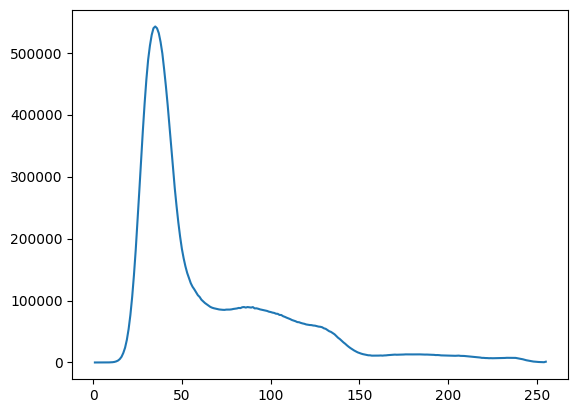

In [ ]:
plt.plot(np.unique(dark_value, return_counts=True)[0], np.unique(dark_value, return_counts=True)[1])

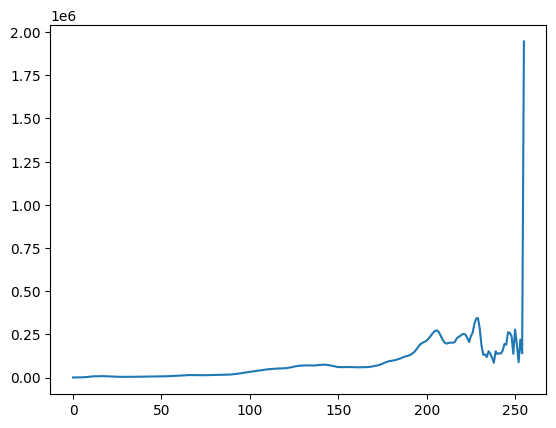

In [ ]:
plt.plot(np.unique(bright_value, return_counts=True)[0], np.unique(bright_value, return_counts=True)[1])

In [ ]:
print ("Mean brightness metric for the dark image = ", np.mean(dark_value))
print ("Mean brightness metric for the bright image = ", np.mean(bright_value))

Mean brightness metric for the dark image =  64.7654030581795
Mean brightness metric for the bright image =  198.32149585865162


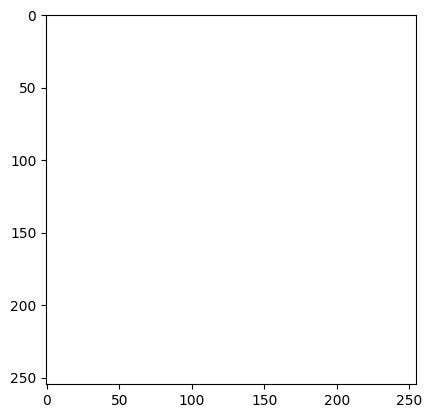

In [ ]:
white_image = np.ones((255, 255, 3))*255
black_image = np.zeros((255, 255, 3))
grey_image = np.ones((255, 255, 3))*127
plt.imshow(grey_image)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteSQIFQ8/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteSQIFQ8/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


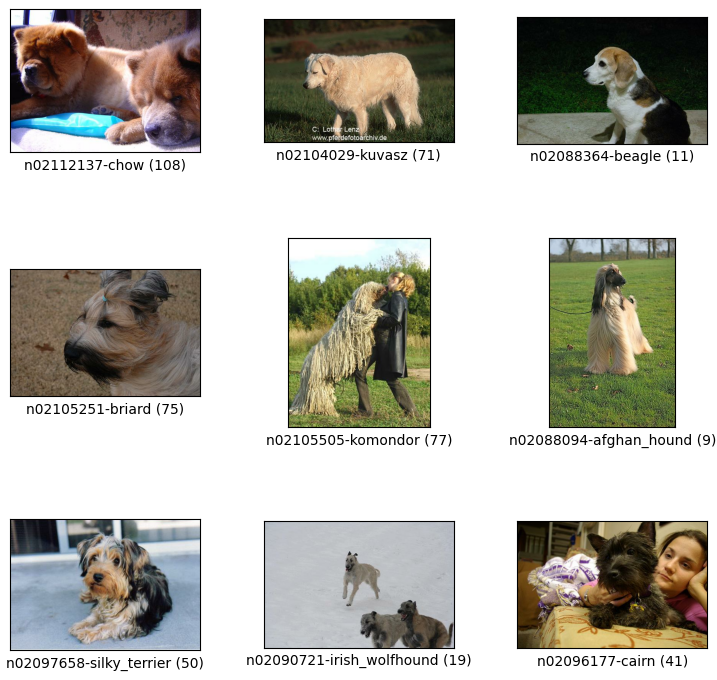

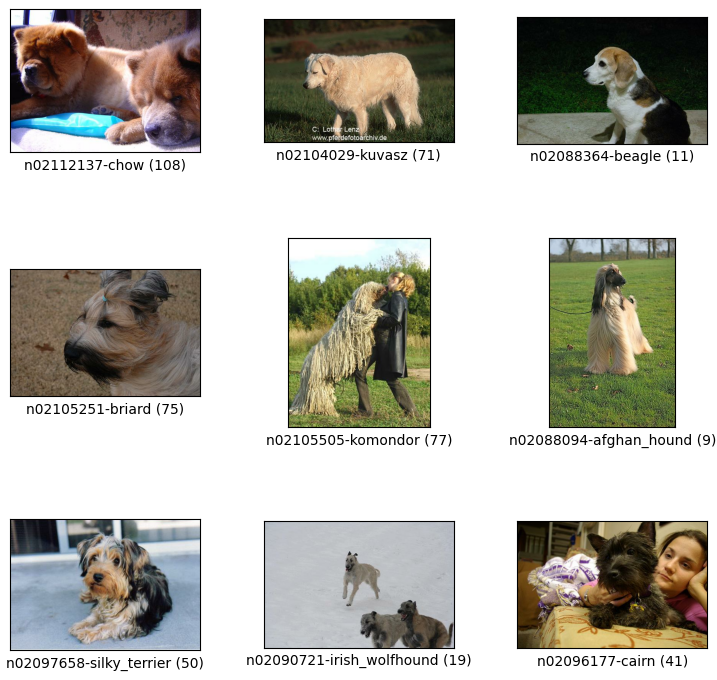

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

ds, ds_info = tfds.load('stanford_dogs', with_info=True, split='test', shuffle_files=True)
tfds.visualization.show_examples(ds, ds_info)


In [ ]:
from tensorflow.python.types import data
ds_sample_of_three_images = ds.take(3)
for dataset_element in list(ds_sample_of_three_images.as_numpy_iterator()):
  image = dataset_element['image']
  print("shape of image: ", image.shape)


shape of image:  (375, 500, 3)
shape of image:  (175, 225, 3)
shape of image:  (500, 464, 3)


8580


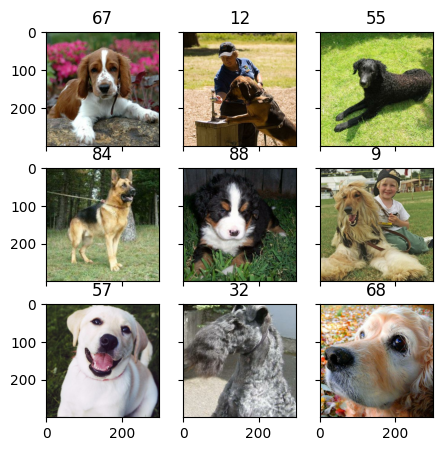

In [ ]:
def pre_processing_function(data_dict):
  data_dict['image'] = tf.keras.layers.Resizing(300, 300, interpolation="bilinear", crop_to_aspect_ratio=True)(data_dict['image'])
  return data_dict
ds_resized = ds.map(pre_processing_function)
# Take one batch from dataset and display the images

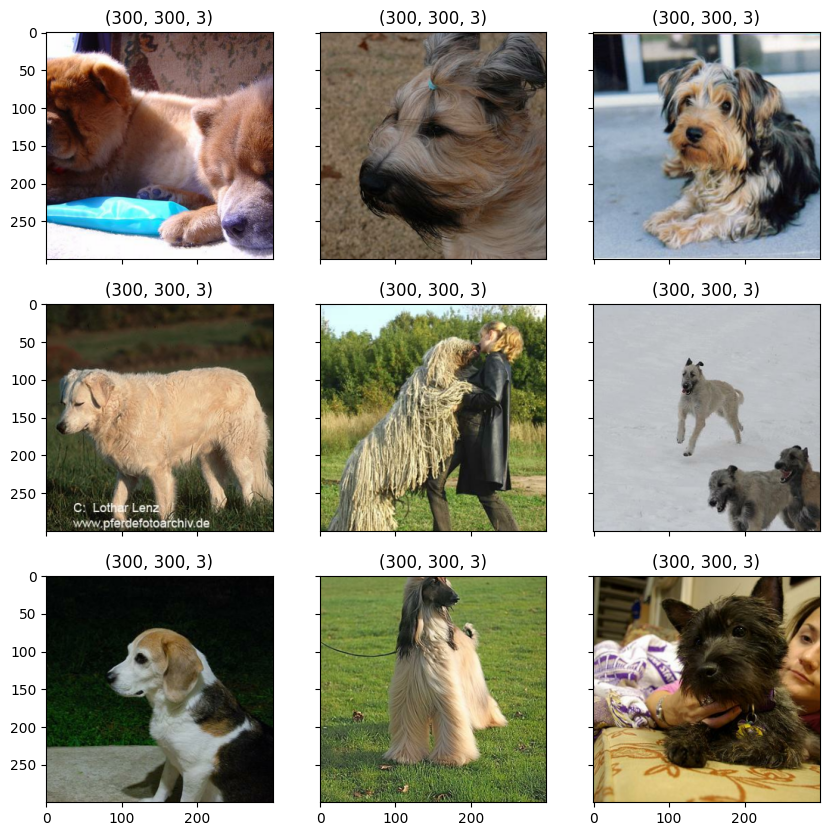

In [ ]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))

ds_sample = ds_resized.take(9)
i=0
for dataset_element in list(ds_sample.as_numpy_iterator()):
    ax[i%3][i//3].imshow(dataset_element['image'].astype("uint8"))
    ax[i%3][i//3].set_title(dataset_element['image'].shape)
    i += 1
plt.show()

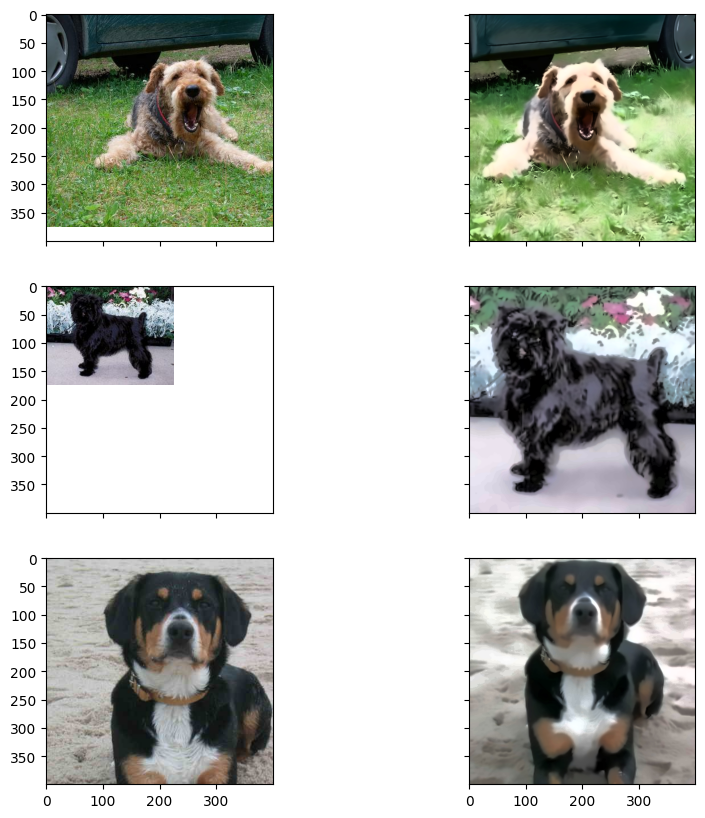

In [ ]:
import cv2
tf.random.set_seed(0)
sample = ds.take(3)
def pre_processing_function(image):

  img = tf.keras.layers.Resizing(400, 400, interpolation="bilinear", crop_to_aspect_ratio=True)(image)

  # Convert from RGB tensor object to BGR numpy object to use with OpenCV
  bgr = img[...,::-1].numpy().copy()

  # Apply cv2 color denoising operation
  bgr = cv2.fastNlMeansDenoisingColored(bgr.astype("uint8"),None,10,10,7,21)

  # convert from BGR representation to YCrCb
  ycrcb_img = cv2.cvtColor(bgr.astype("uint8"), cv2.COLOR_BGR2YCrCb)

  # equalize the histogram on the Y channel which represent the brightness
  ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])

  # convert back to BGR representation
  bgr = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)

  # convert back to RGB and to Tensor format
  final_img = tf.constant(bgr[...,::-1].copy(), tf.uint8)
  img = tf.constant(image.numpy(), tf.uint8)

  return img, final_img

ds_resized = sample.map(lambda x: tf.py_function(pre_processing_function, [x['image']], [tf.uint8, tf.uint8]))
# Take one batch from dataset and display the images
fig, ax = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(10,10))
#ds_sample = ds_resized.take(3)
i=0
for dataset_element in list(ds_resized.as_numpy_iterator()):
    ax[i%3][0].imshow(dataset_element[0].astype("uint8"))
    ax[i%3][1].imshow(dataset_element[1].astype("uint8"))
    i += 1
plt.show()

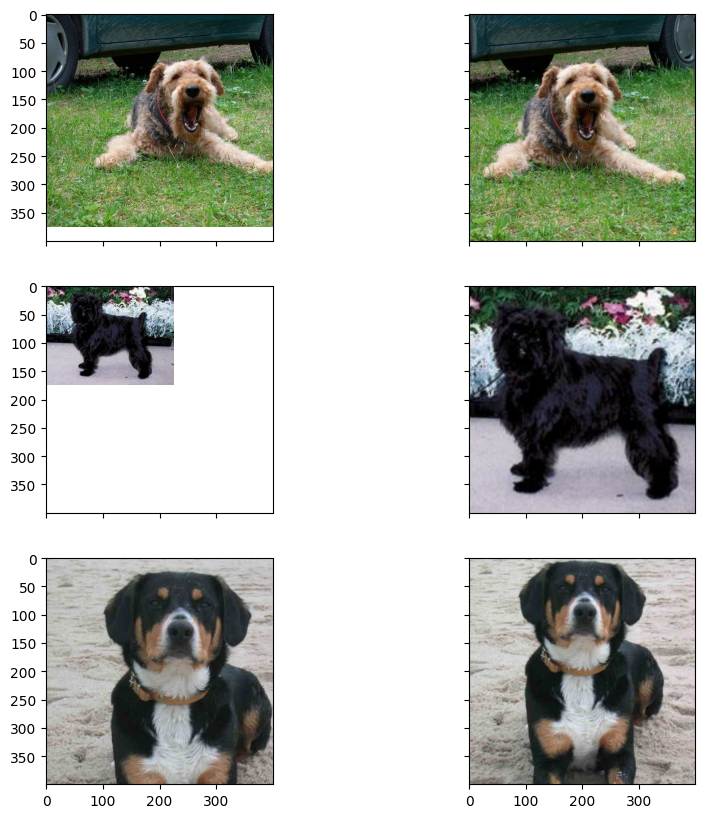

In [ ]:
import cv2
tf.random.set_seed(0)
sample = ds.take(3)

def pre_processing_function(data_dict):
  img = tf.keras.layers.Resizing(400, 400, interpolation="bilinear", crop_to_aspect_ratio=True)(data_dict['image'])
  min_pix = tf.math.reduce_min(img)
  max_pix = tf.math.reduce_max(img)
  final_img = ((img-min_pix)/(max_pix-min_pix))*255
  final_img = tf.cast(final_img, tf.uint8)
  img = tf.cast(data_dict['image'], tf.uint8)
  return img, final_img

ds_resized = sample.map(pre_processing_function)
# Take one batch from dataset and display the images
fig, ax = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(10,10))
#ds_sample = ds_resized.take(3)
i=0
for dataset_element in list(ds_resized.as_numpy_iterator()):
    ax[i%3][0].imshow(dataset_element[0].astype("uint8"))
    ax[i%3][1].imshow(dataset_element[1].astype("uint8"))
    i += 1
plt.show()

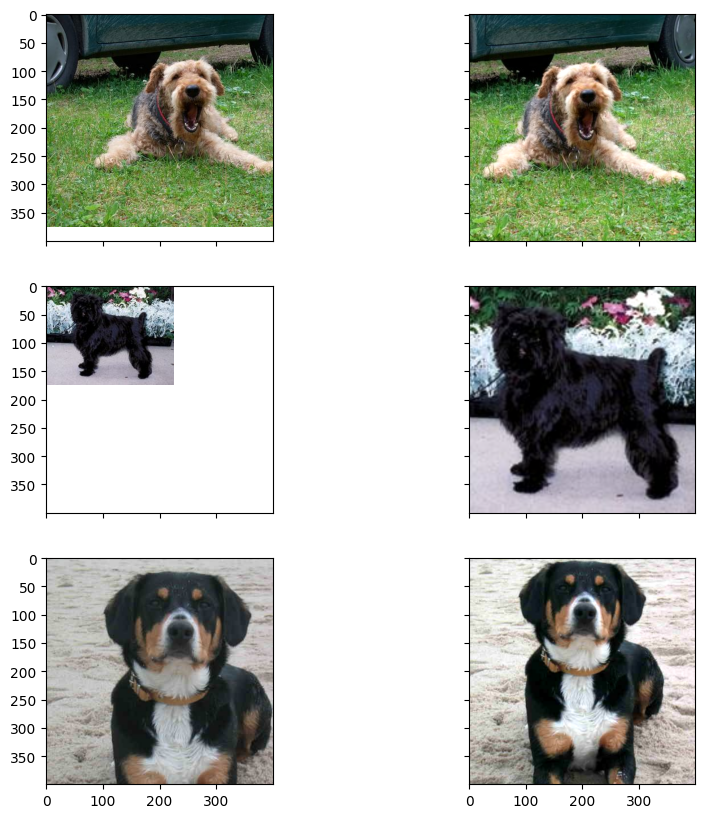

In [ ]:
import cv2
import tensorflow_probability as tfp
tf.random.set_seed(0)
sample = ds.take(3)

def pre_processing_function(data_dict):
  img = tf.keras.layers.Resizing(400, 400, interpolation="bilinear", crop_to_aspect_ratio=True)(data_dict['image'])

  # Apply contrast stretching with clipping
  min_pix = tfp.stats.percentile(img, 1)
  max_pix = tfp.stats.percentile(img, 99)
  final_img = ((img-min_pix)/(max_pix-min_pix))*255
  final_img = tf.math.minimum(tf.math.maximum(final_img, 0), 255)
  final_img = tf.cast(final_img, tf.uint8)
  img = tf.cast(data_dict['image'], tf.uint8)
  return img, final_img

ds_resized = sample.map(pre_processing_function)
# Take one batch from dataset and display the images
fig, ax = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(10,10))
#ds_sample = ds_resized.take(3)
i=0
for dataset_element in list(ds_resized.as_numpy_iterator()):
    ax[i%3][0].imshow(dataset_element[0].astype("uint8"))
    ax[i%3][1].imshow(dataset_element[1].astype("uint8"))
    i += 1
plt.show()

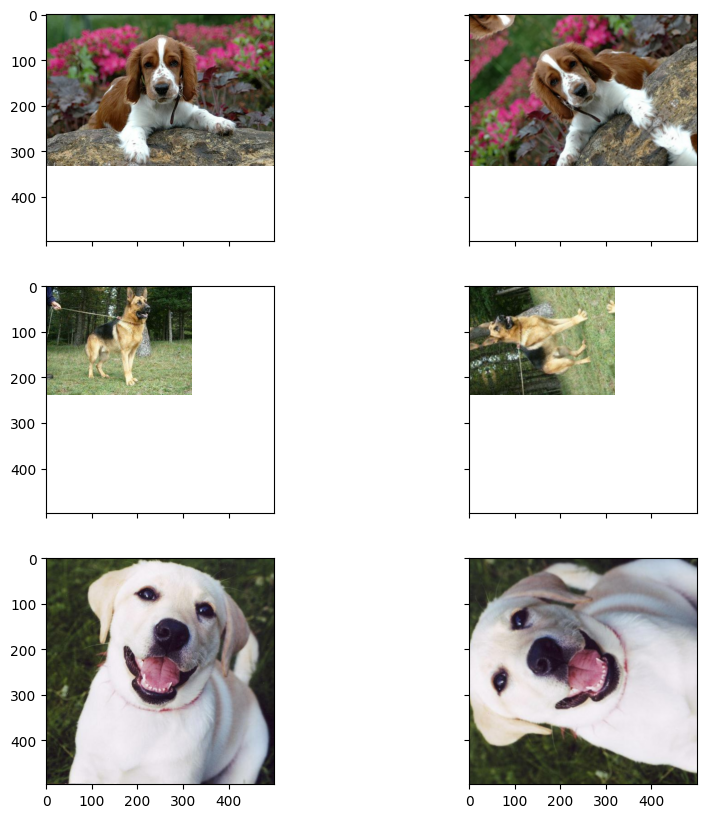

In [ ]:
import cv2
import tensorflow_probability as tfp
tf.random.set_seed(0)
sample = ds.take(3)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.1),
])

ds_augmented = sample.map(lambda x: (x['image'], data_augmentation(x['image'])))
# Take one batch from dataset and display the images
fig, ax = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(10,10))
i=0
for dataset_element in list(ds_augmented.as_numpy_iterator()):
    ax[i%3][0].imshow(dataset_element[0].astype("uint8"))
    ax[i%3][1].imshow(dataset_element[1].astype("uint8"))
    i += 1
plt.show()

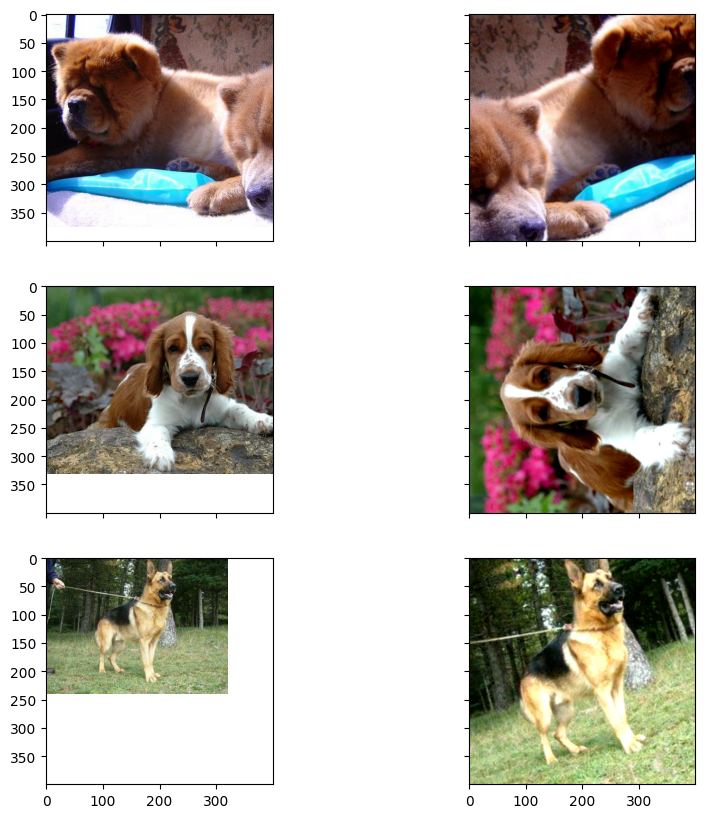

In [ ]:
import cv2
import tensorflow_probability as tfp
tf.random.set_seed(0)
sample = ds.take(3)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.1),
])

def pre_processing_function(data_dict):
  img = tf.keras.layers.Resizing(400, 400, interpolation="bilinear", crop_to_aspect_ratio=True)(data_dict['image'])

  # Apply contrast stretching with clipping
  min_pix = tfp.stats.percentile(img, 5)
  max_pix = tfp.stats.percentile(img, 95)
  final_img = ((img-min_pix)/(max_pix-min_pix))*255
  final_img = tf.math.minimum(tf.math.maximum(final_img, 0), 255)
  final_img = tf.cast(final_img, tf.uint8)
  img = tf.cast(data_dict['image'], tf.uint8)
  return img, final_img

ds_resized = sample.map(pre_processing_function)

ds_augmented = ds_resized.map(lambda x, y: (x, data_augmentation(y)))
# Take one batch from dataset and display the images
fig, ax = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(10,10))
#ds_sample = ds_resized.take(3)
i=0
for dataset_element in list(ds_augmented.as_numpy_iterator()):
    ax[i%3][0].imshow(dataset_element[0].astype("uint8"))
    ax[i%3][1].imshow(dataset_element[1].astype("uint8"))
    i += 1
plt.show()